# Simple California Demo

This notebook shows how to use build a hierarchical clustering of the input features and use it to explain a single instance. This is a good way to explain a single instance when the number of input features is large.
When given a balanced partition tree PartitionExplainer has $O(M^2)$ runtime, where $M$ is the number of input features. This is much better than the $O(2^M)$ runtime of KernelExplainer.

In [1]:
import sys
import numpy as np
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import shap
import pandas as pd

seed = 2023
np.random.seed(seed)

# Train a model

In [2]:
X, y = shap.datasets.california()
model = XGBRegressor(n_estimators=100,subsample=0.3)
model.fit(X, y)

instance = X[0:1]
references = X[1:100]

# Compute a hierarchical clustering of the input features

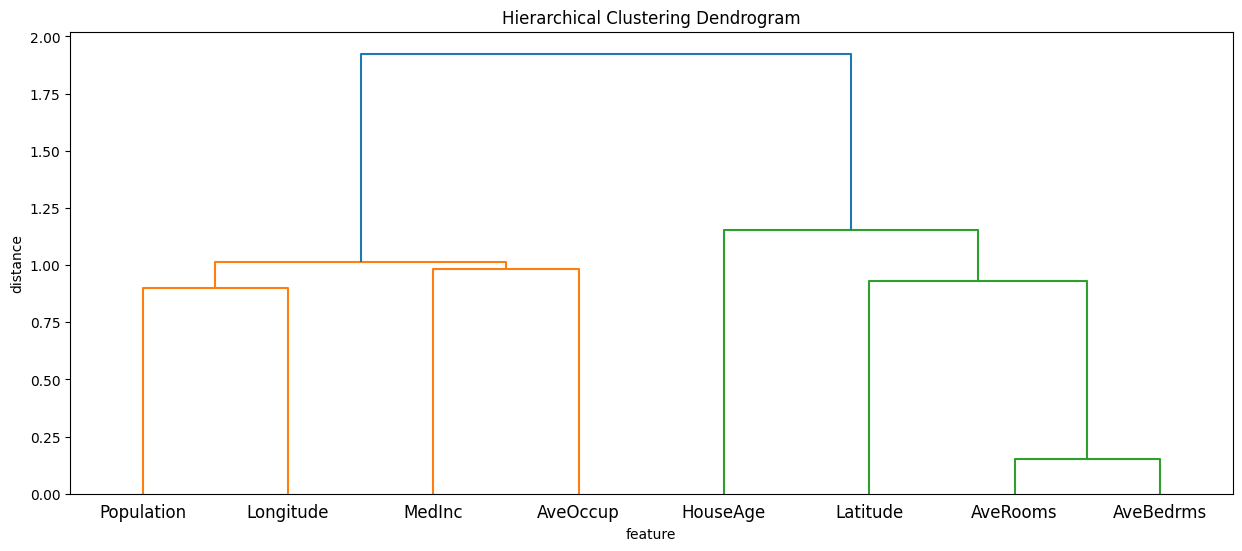

In [3]:
cluster_matrix = shap.utils.partition_tree(X)
plt.figure(figsize=(15,6))
sp.cluster.hierarchy.dendrogram(cluster_matrix, labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

# Explain the instance

In [4]:
# build a masker from partition tree
masker = shap.maskers.Partition(X, clustering=cluster_matrix)

# build explainer objects
raw_explainer = shap.PartitionExplainer(model.predict, X)
masker_explainer = shap.explainers.Partition(model.predict, masker)

# compute SHAP values
raw_shap_values = raw_explainer(instance)
masker_shap_values = masker_explainer(instance)

In [5]:
# comparison the masker and the original data sizes
print(f"X size: {sys.getsizeof(X)/1024:.2f} kB")
print(f"masker size: {sys.getsizeof(masker)} B")

X size: 1290.16 kB
masker size: 56 B


# Compare to Tree SHAP

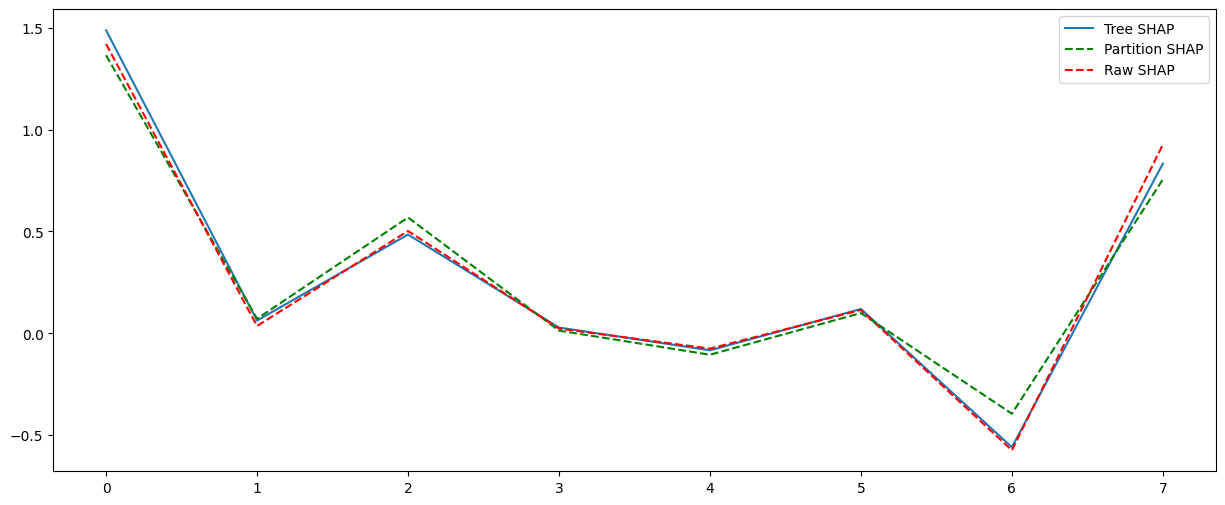

In [6]:
tree_explainer = shap.TreeExplainer(model, X)
tree_shap_values = tree_explainer(instance)

plt.figure(figsize=(15,6))
plt.plot(tree_shap_values[0].values, label="Tree SHAP")
plt.plot(masker_shap_values[0].values, "g--",label="Partition SHAP")
plt.plot(raw_shap_values[0].values, "r--",label="Raw SHAP")

plt.legend()
plt.show()